# PRAKTIKUM K-MEAN CLUSTERING

1. Import Library

In [49]:
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

2. Konek ke Gdrive

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


3. Loading dataset

In [51]:
# Membaca dataset
df = pd.read_csv('/content/drive/MyDrive/Praktikum_ML/Praktikum11/data/Iris.csv')
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [52]:
# Menampilkan informasi detail dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [53]:
# Cek missing value
df.isnull().sum()

,0
Id,0
SepalLengthCm,0
SepalWidthCm,0
PetalLengthCm,0
PetalWidthCm,0
Species,0


In [54]:
# Cek data duplikat
df.duplicated().sum()

np.int64(0)

In [55]:
# Menampilkan statistika deskriptif dari dataset
df.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


In [56]:
# Cek nilai pada kolom Species
df['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [57]:
# Menghitung jumlah pada kolom Species
df['Species'].value_counts()

,count
Species,
Iris-setosa,50
Iris-versicolor,50
Iris-virginica,50


4. Pemilihan Fitur

In [58]:
# Memisahkan atara fitur(x) dan label(y)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['SpeciesEncoded'] = le.fit_transform(df['Species'])

In [59]:
# Fitur untuk clustering
X = df.drop(['Id', 'Species', 'SpeciesEncoded'], axis=1)

In [60]:
X

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


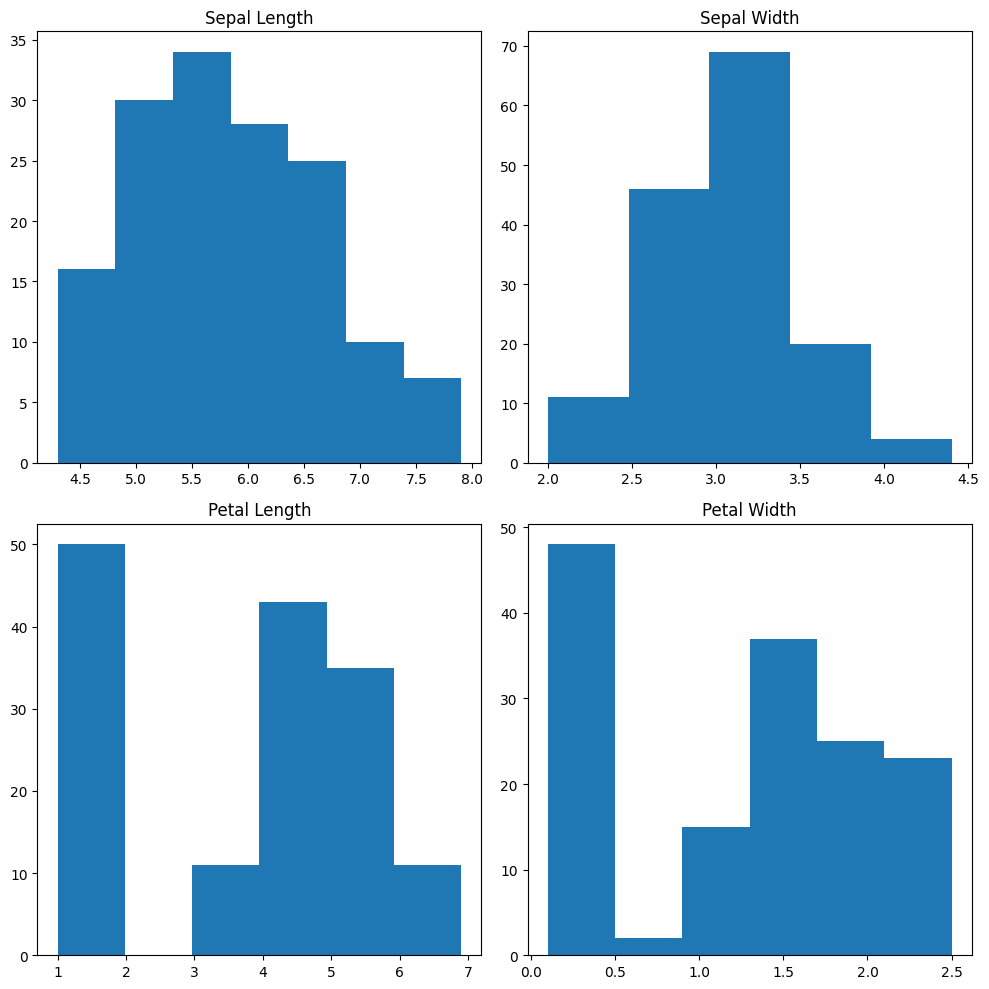

In [61]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Histogram 1 : Sepal Length
axes[0, 0].set_title("Sepal Length")
axes[0, 0].hist(X["SepalLengthCm"], bins=7)

# Histogram 2 : Sepal Width
axes[0, 1].set_title("Sepal Width")
axes[0, 1].hist(X["SepalWidthCm"], bins=5)

# Histogram 1 : Petal Length
axes[1, 0].set_title("Petal Length")
axes[1, 0].hist(X["PetalLengthCm"], bins=6)

# Histogram 1 : Petal Width
axes[1, 1].set_title("Petal Width")
axes[1, 1].hist(X["PetalWidthCm"], bins=6)

plt.tight_layout()
plt.show()

In [62]:
# Menentukan StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#Re-initialite X from the originial Dataframe 'df'
# This ensires X is a Dataframe with named columns for indxing before scalling
X = df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]

# Now apply the scalling
X= scaler.fit_transform(X)
X[:5]

array([[-0.90068117,  1.03205722, -1.3412724 , -1.31297673],
       [-1.14301691, -0.1249576 , -1.3412724 , -1.31297673],
       [-1.38535265,  0.33784833, -1.39813811, -1.31297673],
       [-1.50652052,  0.10644536, -1.2844067 , -1.31297673],
       [-1.02184904,  1.26346019, -1.3412724 , -1.31297673]])

5. Menentukan jumlah cluster (K) dengan Elbow Method

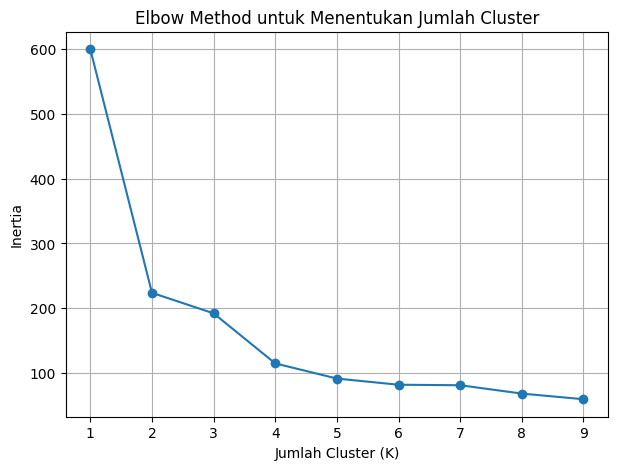

In [63]:
# Memplot nilai inertia tergadap jumlah cluster
inertia_list = []
K_range = range(1, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertia_list.append(km.inertia_)

plt.figure(figsize=(7, 5))
plt.plot(K_range, inertia_list, marker='o')
plt.title('Elbow Method untuk Menentukan Jumlah Cluster')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

6. Membangun Model K-Means

In [64]:
kmeans = KMeans(
    n_clusters=3, # Karena dataset iris ada 3 spesies
    init='k-means++',
    random_state=42
    )

In [65]:
# 1. Latih model (menetukan centroid + proses clustering)
# kmeans.fit(X)

# 2. Prediksi cluster  untuk data X
#labels = kmeans.predict(X)

In [66]:
# 3. Masukkan ke DataFrame
#df['Cluster'] = labels

In [67]:
df["Cluster"] = kmeans.fit_predict(X)

print("Cluster ditemukan:", df["Cluster"].unique())

Cluster ditemukan: [1 2 0]


7. Evaluasi Kualitas Clustering

In [68]:
sil_score = silhouette_score(X, df["Cluster"])
print("\n===== SILHOUETTE SCORE =====")
print("Silhouette Score:", sil_score)


===== SILHOUETTE SCORE =====
Silhouette Score: 0.4787241921049546


8. Confusion Matrix (Perbandingan dengan label asli)

In [69]:
from sklearn.metrics import confusion_matrix, classification_report
print('\n===== CONFUSION MATRIX =====\n')
cm = confusion_matrix(df['SpeciesEncoded'], df['Cluster'])
print(cm)


===== CONFUSION MATRIX =====

[[ 0 32 18]
 [46  0  4]
 [50  0  0]]


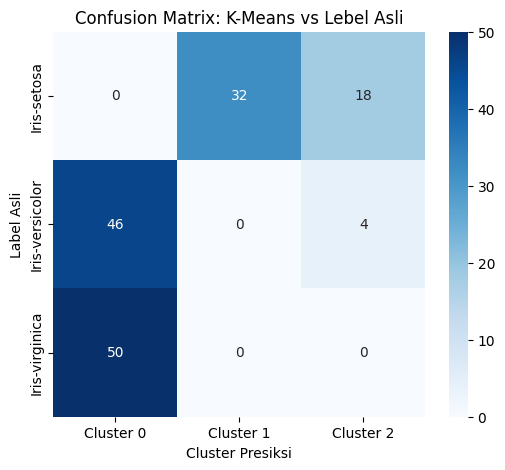

In [70]:
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Cluster 0', 'Cluster 1', 'Cluster 2'],
    yticklabels=le.classes_
    )

plt.title('Confusion Matrix: K-Means vs Lebel Asli')
plt.xlabel('Cluster Presiksi')
plt.ylabel('Label Asli')
plt.show()

9. 2D dan 3D visualisasi hasil model K-means

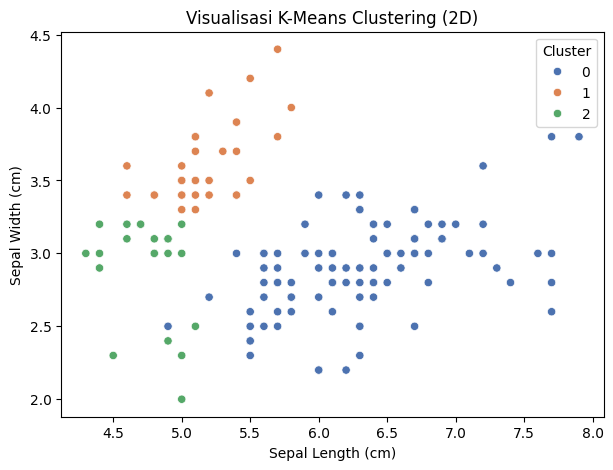

In [71]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=df["SepalLengthCm"],
    y=df["SepalWidthCm"],
    hue=df["Cluster"],
    palette="deep"
)
plt.title("Visualisasi K-Means Clustering (2D)")
plt.xlabel("Sepal Length (cm)")
plt.ylabel("Sepal Width (cm)")
plt.show()

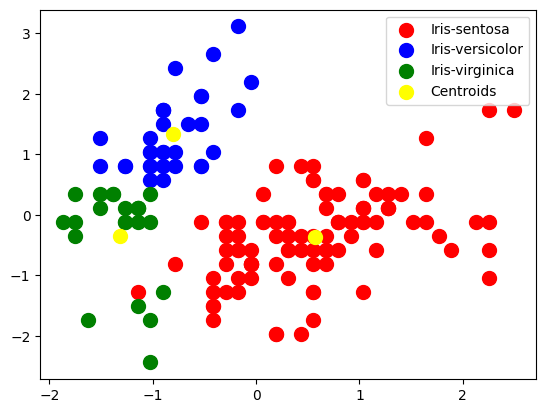

In [72]:
# Visualising the clusters
plt.scatter(X[df["Cluster"] == 0, 0], X[df["Cluster"] == 0, 1], s = 100, c = 'red', label = 'Iris-sentosa')
plt.scatter(X[df["Cluster"] == 1, 0], X[df["Cluster"] == 1, 1], s = 100, c = 'blue', label = 'Iris-versicolor')
plt.scatter(X[df["Cluster"] == 2, 0], X[df["Cluster"] == 2, 1], s = 100, c = 'green', label = 'Iris-virginica')

# Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')

plt.legend()
plt.show()

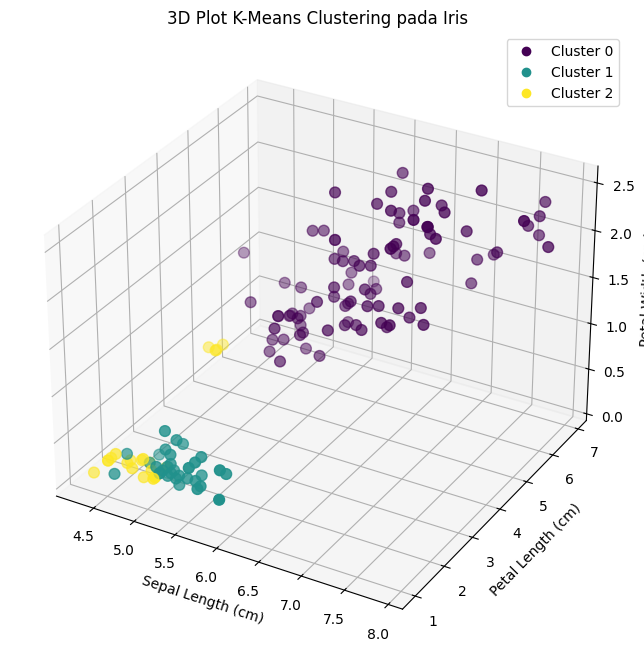

In [73]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df["SepalLengthCm"],
    df["PetalLengthCm"],
    df["PetalWidthCm"],
    c=df["Cluster"],
    s=60
)

ax.set_title("3D Plot K-Means Clustering pada Iris")
ax.set_xlabel("Sepal Length (cm)")
ax.set_ylabel("Petal Length (cm)")
ax.set_zlabel("Petal Width (cm)")

# Legend cluster
legend_labels = [f"Cluster {i}" for i in range(3)]
ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels)

plt.show()

# PRAKTIKUM MANDIRI DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

1. Install Library tambahan

In [74]:
!pip install folium

In [75]:
!pip install contextily

In [76]:
!pip install geopandas contextily

2. Import Library

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from folium.plugins import HeatMap
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import wkt

3. Load Dataset

* Membaca dataset




In [78]:
# Dataset polusi
df_poll = pd.read_csv('/content/drive/MyDrive/Praktikum_ML/Praktikum11/data/global_air_pollution_dataset.csv')

# Dataset Koordinat
df_city = pd.read_csv('/content/drive/MyDrive/Praktikum_ML/Praktikum11/data/worldcities.csv')

* Menampilkan dataset

In [79]:
df_poll.head()

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36,Good,0,Good,51,Moderate
1,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good
2,Italy,Priolo Gargallo,66,Moderate,1,Good,39,Good,2,Good,66,Moderate
3,Poland,Przasnysz,34,Good,1,Good,34,Good,0,Good,20,Good
4,France,Punaauia,22,Good,0,Good,22,Good,0,Good,6,Good


In [80]:
df_city.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6870,139.7495,Japan,JP,JPN,Tōkyō,primary,37785000.0,1392685764
1,Jakarta,Jakarta,-6.1750,106.8275,Indonesia,ID,IDN,Jakarta,primary,33756000.0,1360771077
2,Delhi,Delhi,28.6100,77.2300,India,IN,IND,Delhi,admin,32226000.0,1356872604
3,Guangzhou,Guangzhou,23.1300,113.2600,China,CN,CHN,Guangdong,admin,26940000.0,1156237133
4,Mumbai,Mumbai,19.0761,72.8775,India,IN,IND,Mahārāshtra,admin,24973000.0,1356226629


* Menggabungkan dataset

In [81]:
# Menyamakan nama kolom di df_poll (huruf kecil, tanpa spasi di depan/belakang)
df_poll["City"] = df_poll["City"].str.lower().str.strip()
df_poll["Country"] = df_poll["Country"].str.lower().str.strip()

# Menyamakan nama kolom di df_city
df_city["city"] = df_city["city"].str.lower().str.strip()
df_city["country"] = df_city["country"].str.lower().str.strip()


In [82]:
# Menggabungkan dataset polusi dengan koordinat kota
df_merged = df_poll.merge(
    df_city[["city", "country", "lat", "lng"]],  # hanya ambil kolom yang diperlukan
    left_on=["City", "Country"],                 # kolom kunci di df_poll
    right_on=["city", "country"],               # kolom kunci di df_city
    how="left"                                  # left join: semua data polusi dipertahankan
)

# Menghapus kolom 'city' dan 'country' dari df_city agar tidak dobel
df_merged = df_merged.drop(columns=["city", "country"])

df_merged.head()


,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category,lat,lng
0,russian federation,praskoveya,51,Moderate,1,Good,36,Good,0,Good,51,Moderate,NaN,NaN
1,brazil,presidente dutra,41,Good,1,Good,5,Good,1,Good,41,Good,-5.2900,-44.4900
2,italy,priolo gargallo,66,Moderate,1,Good,39,Good,2,Good,66,Moderate,37.1667,15.1833
3,poland,przasnysz,34,Good,1,Good,34,Good,0,Good,20,Good,53.0167,20.8833
4,france,punaauia,22,Good,0,Good,22,Good,0,Good,6,Good,NaN,NaN


*  Menampilkan informasi dataset

In [83]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23836 entries, 0 to 23835
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             23409 non-null  object 
 1   City                23835 non-null  object 
 2   AQI Value           23836 non-null  int64  
 3   AQI Category        23836 non-null  object 
 4   CO AQI Value        23836 non-null  int64  
 5   CO AQI Category     23836 non-null  object 
 6   Ozone AQI Value     23836 non-null  int64  
 7   Ozone AQI Category  23836 non-null  object 
 8   NO2 AQI Value       23836 non-null  int64  
 9   NO2 AQI Category    23836 non-null  object 
 10  PM2.5 AQI Value     23836 non-null  int64  
 11  PM2.5 AQI Category  23836 non-null  object 
 12  lat                 10387 non-null  float64
 13  lng                 10387 non-null  float64
dtypes: float64(2), int64(5), object(7)
memory usage: 2.5+ MB


4. Data Cleaning

*  Cek missing value

In [84]:
df_merged.isnull().sum()

,0
Country,427
City,1
AQI Value,0
AQI Category,0
CO AQI Value,0
CO AQI Category,0
Ozone AQI Value,0
Ozone AQI Category,0
NO2 AQI Value,0
NO2 AQI Category,0


* Menghapus missing value

In [85]:
df_merged = df_merged.dropna(subset=["lat", "lng"])

* Mencek kembali missing value

In [86]:
df_merged.isnull().sum()

,0
Country,0
City,0
AQI Value,0
AQI Category,0
CO AQI Value,0
CO AQI Category,0
Ozone AQI Value,0
Ozone AQI Category,0
NO2 AQI Value,0
NO2 AQI Category,0


* Cek duplikasi

In [87]:
df.duplicated().sum()

np.int64(0)

5. Exploratory Data Analysis (EDA)

* Visualisasi Heatmap Sebaran Polusi Udara (AQI)

In [88]:
# Membuat peta dasar dunia (center di 0,0 agar terlihat semua kota)
peta_polusi = folium.Map(location=[20, 0], zoom_start=2)

# Membuat list [lat, lng, aqi] untuk heatmap
data_heatmap = df_merged[['lat', 'lng', 'AQI Value']].values.tolist()

# Menambahkan heatmap ke peta
HeatMap(
    data_heatmap,
    radius=12,
    blur=15,
    max_zoom=6
).add_to(peta_polusi)

# Tampilkan peta
peta_polusi


* Visualisasi Peta Sebaran Polusi Udara dengan Basemap

<Figure size 1800x1000 with 0 Axes>

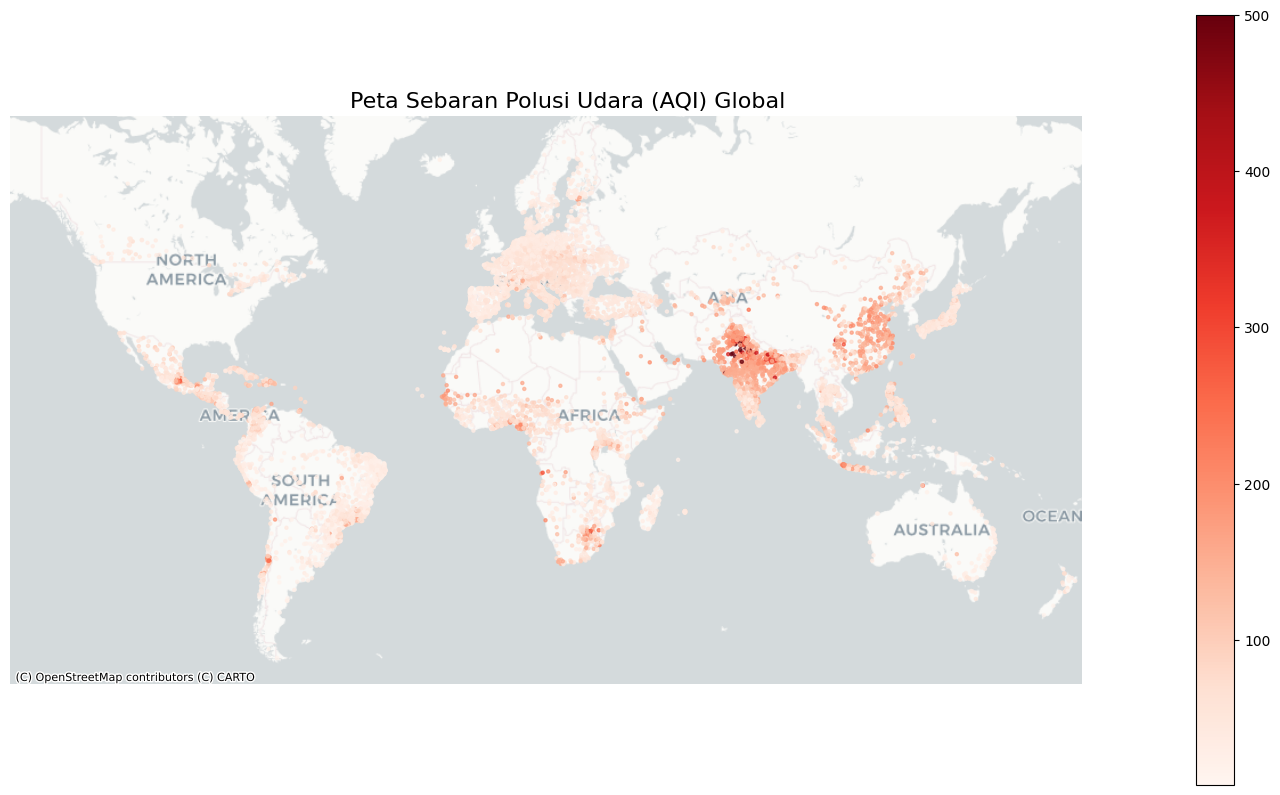

In [89]:
# Membuat GeoDataFrame dari df_merged
gdf = gpd.GeoDataFrame(
    df_merged,
    geometry=gpd.points_from_xy(df_merged.lng, df_merged.lat),
    crs="EPSG:4326"   # koordinat WGS84
)

# Proyeksi ke Web Mercator
gdf = gdf.to_crs(epsg=3857)

plt.figure(figsize=(18, 10))

ax = gdf.plot(
    figsize=(18, 10),
    column='AQI Value',     # pewarnaan berdasarkan AQI
    cmap='Reds',            # warna merah untuk polusi tinggi
    markersize=5,
    alpha=0.7,
    legend=True
)

# Tambahkan basemap dunia (ganti Stamen → CartoDB.Positron)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Hilangkan axis
ax.set_axis_off()

plt.title("Peta Sebaran Polusi Udara (AQI) Global", fontsize=16)
plt.show()


* Grafik Bar – Kota dengan AQI Tertinggi & Terendah

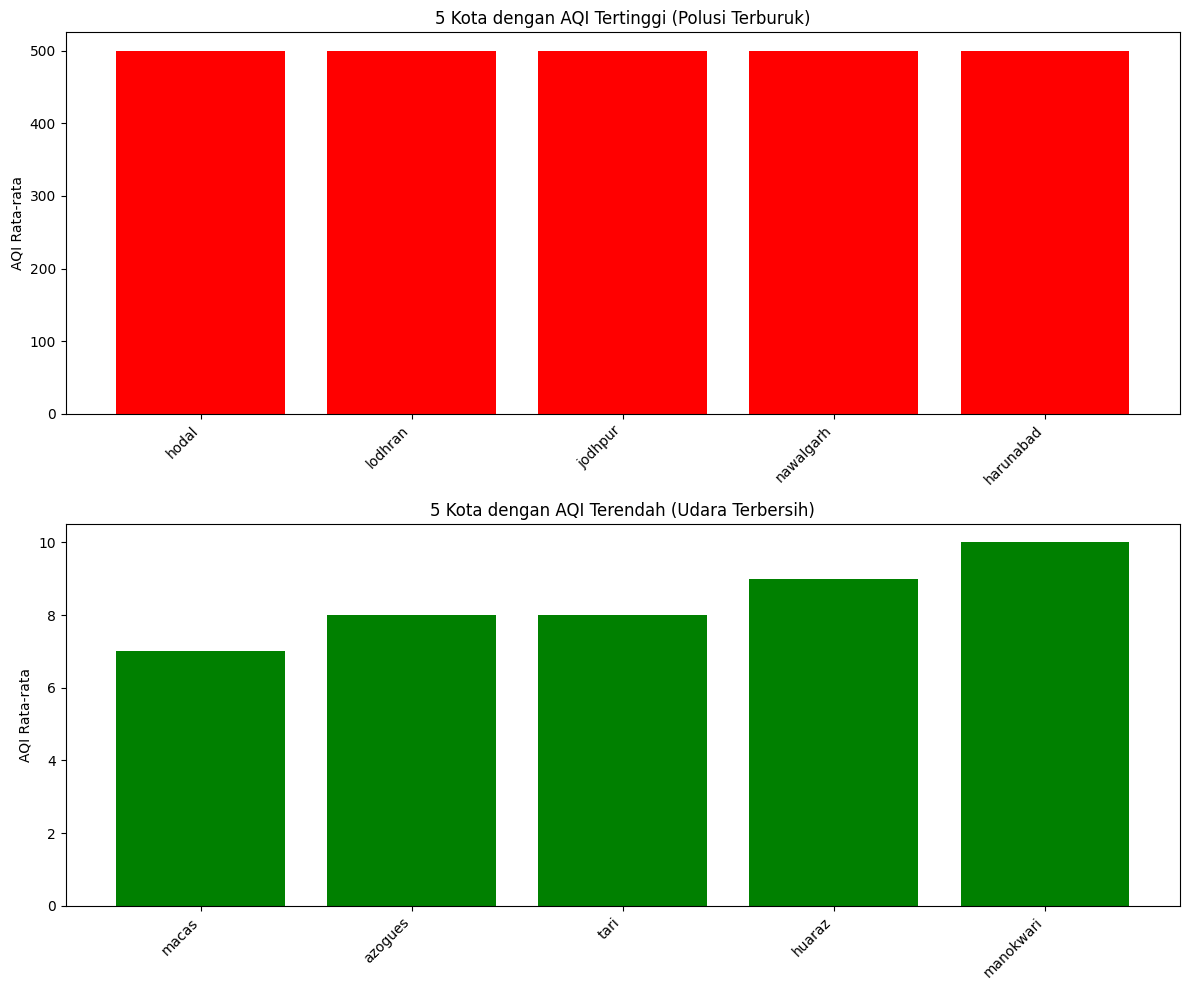

In [90]:
import matplotlib.pyplot as plt

# Menghitung rata-rata AQI per kota
aqi_kota = df_merged.groupby("City")["AQI Value"].mean()

# Ambil 5 kota AQI tertinggi & terendah
top_5 = aqi_kota.sort_values(ascending=False).head(5)
bottom_5 = aqi_kota.sort_values(ascending=True).head(5)

plt.figure(figsize=(12, 10))

# Grafik AQI tertinggi (atas)
plt.subplot(2, 1, 1)
plt.bar(top_5.index, top_5.values, color='red')
plt.title("5 Kota dengan AQI Tertinggi (Polusi Terburuk)")
plt.ylabel("AQI Rata-rata")
plt.xticks(rotation=45, ha='right')

# Grafik AQI terendah (bawah)
plt.subplot(2, 1, 2)
plt.bar(bottom_5.index, bottom_5.values, color='green')
plt.title("5 Kota dengan AQI Terendah (Udara Terbersih)")
plt.ylabel("AQI Rata-rata")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


6. Uji Normalitas (Shapiro-Wilk Test)

In [91]:
import pandas as pd
from scipy.stats import shapiro

# 1. Ambil hanya kolom numerik
numeric_df = df_merged.select_dtypes(include=['int64', 'float64'])

print("Kolom numerik yang diuji:")
print(numeric_df.columns)
print()

# 2. Sampling (supaya tidak terlalu besar untuk Shapiro)
#    ambil max 5000 baris secara acak
n_sample = min(5000, len(numeric_df))
sample_values = numeric_df.sample(n_sample, random_state=42).values.flatten()

# 3. Uji normalitas Shapiro-Wilk
stat, p = shapiro(sample_values)

print("=== Hasil Uji Normalitas Shapiro-Wilk ===")
print("Statistik :", stat)
print("p-value   :", p)

# 4. Interpretasi
alpha = 0.05
if p > alpha:
    print("Kesimpulan: Data berdistribusi NORMAL (gagal tolak H0).")
else:
    print("Kesimpulan: Data TIDAK berdistribusi normal (tolak H0).")


Kolom numerik yang diuji:
Index(['AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value',
       'PM2.5 AQI Value', 'lat', 'lng'],
      dtype='object')

=== Hasil Uji Normalitas Shapiro-Wilk ===
Statistik : 0.8483084623357117
p-value   : 2.7679361006997974e-99
Kesimpulan: Data TIDAK berdistribusi normal (tolak H0).


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 35000.
  res = hypotest_fun_out(*samples, **kwds)


7. Analisis Korelasi (Spearman Correlation Heatmap)

Kolom yang digunakan untuk korelasi:
Index(['AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value',
       'PM2.5 AQI Value'],
      dtype='object')

Matriks Korelasi Spearman:
                 AQI Value  CO AQI Value  Ozone AQI Value  NO2 AQI Value  \
AQI Value         1.000000      0.635606         0.240038       0.273734   
CO AQI Value      0.635606      1.000000         0.053962       0.472212   
Ozone AQI Value   0.240038      0.053962         1.000000      -0.223360   
NO2 AQI Value     0.273734      0.472212        -0.223360       1.000000   
PM2.5 AQI Value   0.962242      0.611342         0.124496       0.312954   

                 PM2.5 AQI Value  
AQI Value               0.962242  
CO AQI Value            0.611342  
Ozone AQI Value         0.124496  
NO2 AQI Value           0.312954  
PM2.5 AQI Value         1.000000  


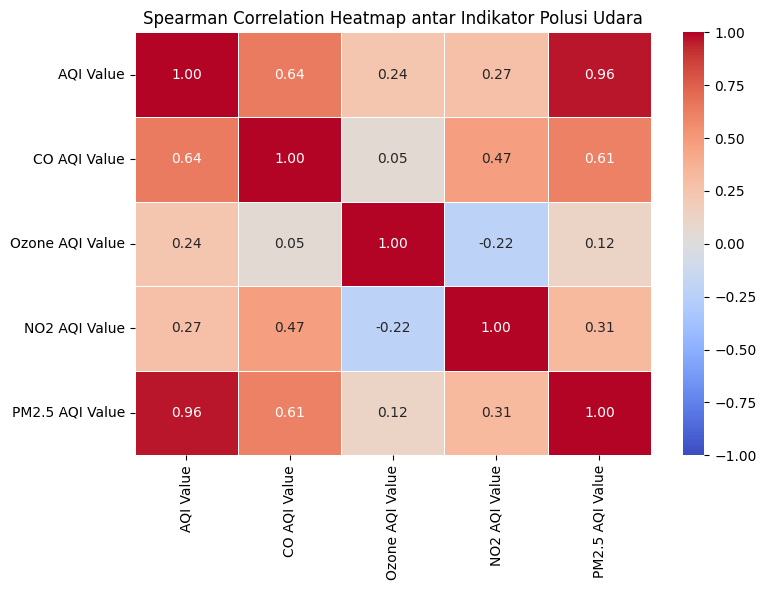

In [92]:
# Asumsi: df_merged = dataset bersih (sudah tidak ada missing value & duplikat)

# 1. Pilih kolom numerik yang relevan untuk korelasi
#    (fokus ke indikator polusi aja, tidak termasuk lat/lng)
korelasi_df = df_merged[[
    "AQI Value",
    "CO AQI Value",
    "Ozone AQI Value",
    "NO2 AQI Value",
    "PM2.5 AQI Value"
]]

print("Kolom yang digunakan untuk korelasi:")
print(korelasi_df.columns)
print()

# 2. Hitung matriks korelasi Spearman
corr_matrix = korelasi_df.corr(method='spearman')

print("Matriks Korelasi Spearman:")
print(corr_matrix)

# 3. Visualisasi heatmap korelasi
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,        # tampilkan angka korelasi di dalam kotak
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5
)
plt.title("Spearman Correlation Heatmap antar Indikator Polusi Udara")
plt.tight_layout()
plt.show()


9. Normalisasi Data dengan RobustScaler

In [93]:
from sklearn.preprocessing import RobustScaler

# 1. Pilih kolom numerik relevan
fitur_numerik = df_merged[[
    "AQI Value",
    "CO AQI Value",
    "Ozone AQI Value",
    "NO2 AQI Value",
    "PM2.5 AQI Value"
]]

# 2. Simpan nama kolom
kolom_fitur = fitur_numerik.columns

# 3. Terapkan RobustScaler
scaler = RobustScaler()
data_normalized = scaler.fit_transform(fitur_numerik)

# 4. Konversi kembali ke DataFrame
df_normalized = pd.DataFrame(data_normalized, columns=kolom_fitur)

# Lihat hasil normalisasi
df_normalized.head()


,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value
0,-0.324324,0.0,-1.315789,0.000000,-0.292683
1,0.351351,0.0,0.473684,0.333333,0.317073
2,-0.513514,0.0,0.210526,-0.333333,-0.804878
3,0.297297,0.0,-0.052632,2.000000,0.268293
4,0.405405,1.0,2.000000,0.000000,0.121951


10. Menentukan Parameter ε (epsilon) dengan K-Distance Graph

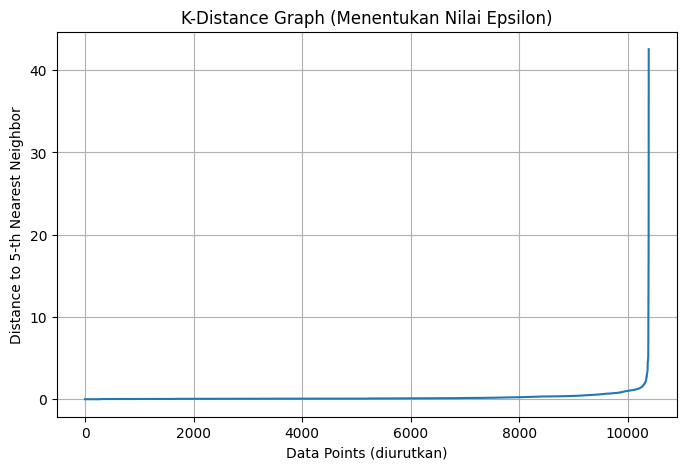

In [94]:
from sklearn.neighbors import NearestNeighbors

# 1. Konversi dataframe menjadi array numpy
data = df_normalized.values

# 2. Menentukan jumlah tetangga (min_samples biasanya 5)
min_samples = 5

# 3. Menghitung neighbor distances
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(data)
distances, indices = neighbors_fit.kneighbors(data)

# 4. Ambil jarak tetangga ke-5 (karena n_neighbors = 5)
k_distances = np.sort(distances[:, min_samples - 1])

# 5. Plot grafik K-Distance
plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.title("K-Distance Graph (Menentukan Nilai Epsilon)")
plt.xlabel("Data Points (diurutkan)")
plt.ylabel(f"Distance to {min_samples}-th Nearest Neighbor")
plt.grid(True)
plt.show()

11. Clustering dengan DBSCAN

In [96]:
from sklearn.cluster import DBSCAN

# Tentukan nilai eps berdasarkan grafik K-Distance
eps_value = 0.5      # ganti sesuai hasil grafik kamu
min_samples = 5

# Menjalankan DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
labels = dbscan.fit_predict(df_normalized.values)

# Menambahkan hasil cluster ke dataframe asli
df_merged["Cluster_DBSCAN"] = labels

# Menampilkan ringkasan jumlah anggota setiap cluster
print("=== Jumlah Data per Cluster (Versi Modul) ===")
print(df_merged["Cluster_DBSCAN"].value_counts())

=== Jumlah Data per Cluster (Versi Modul) ===
Cluster_DBSCAN
 0     6486
 2     1578
 1      920
-1      875
 5       97
 3       93
 9       29
 6       25
 26      23
 13      22
 4       19
 20      17
 7       16
 17      16
 19      12
 18      11
 14      10
 24       9
 31       9
 34       8
 11       8
 10       7
 35       7
 15       7
 23       7
 16       7
 30       6
 33       6
 32       6
 21       6
 8        5
 27       5
 29       5
 12       5
 28       5
 36       5
 22       5
 25       5
 37       5
Name: count, dtype: int64


12. Evaluasi Clustering dengan Silhouette Score

In [97]:
from sklearn.metrics import silhouette_score

# Samakan index terlebih dahulu
df_normalized = df_normalized.reset_index(drop=True)
df_merged = df_merged.reset_index(drop=True)

labels = df_merged["Cluster_DBSCAN"]

# Hanya gunakan data yang bukan noise
mask = labels != -1

# Hitung silhouette score
skor_silhouette = silhouette_score(
    df_normalized[mask],
    labels[mask]
)

print("Silhouette Score:", round(skor_silhouette, 4))


Silhouette Score: 0.1506


13. Visualisasi Hasil Clustering dengan PCA (2D)

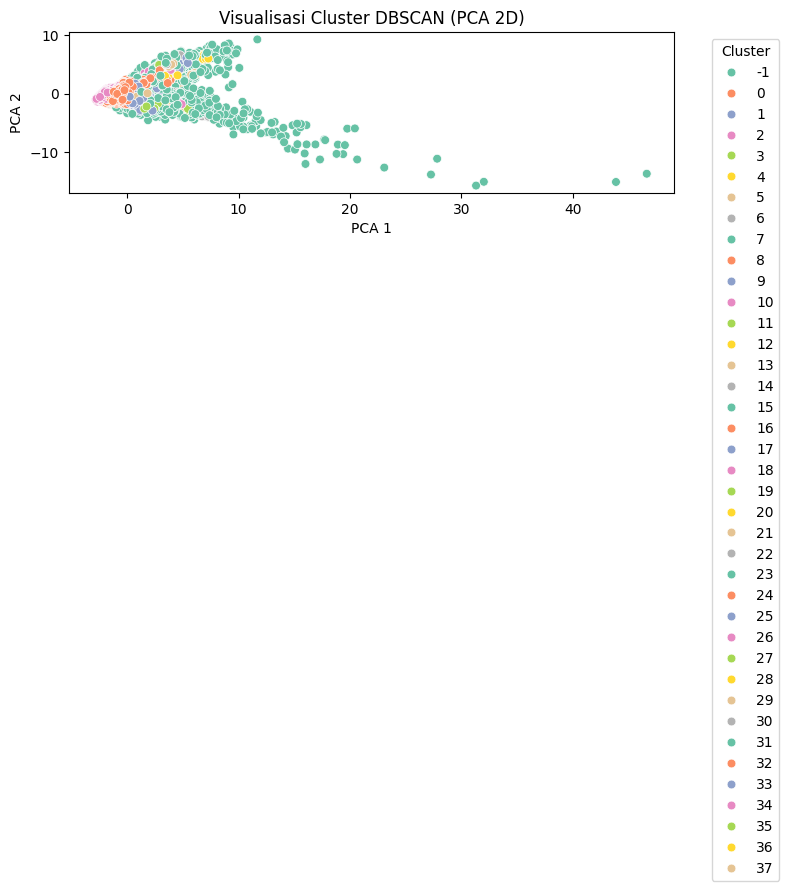

In [98]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. PCA dengan 2 komponen (2D)
pca = PCA(n_components=2)
reduced = pca.fit_transform(df_normalized)   # df_normalized = data yang sudah dinormalisasi

# 2. Siapkan label cluster
labels = df_merged["Cluster_DBSCAN"]

# 3. Plot scatter PCA 2D dengan warna per cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=reduced[:, 0],
    y=reduced[:, 1],
    hue=labels,
    palette="Set2",
    s=40
)

plt.title("Visualisasi Cluster DBSCAN (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


14. Pengelompokan Kualitatif Cluster

In [99]:
def klasifikasi_db(x):
    if x == 0:
        return "Baik"
    elif x == -1:
        return "Noise"
    else:
        return "Kurang"

# Membuat kolom klasifikasi baru
df_merged["Klasifikasi_DBSCAN"] = df_merged["Cluster_DBSCAN"].apply(klasifikasi_db)

# Melihat ringkasan jumlah setiap kategori
print(df_merged["Klasifikasi_DBSCAN"].value_counts())


Klasifikasi_DBSCAN
Baik      6486
Kurang    3026
Noise      875
Name: count, dtype: int64


15. Analisis Lanjutan per Cluster (Cluster Summary)

In [100]:
# 1. Ambil hanya kolom numerik (supaya tidak error waktu dihitung mean)
numeric_cols = df_merged.select_dtypes(include=["float64", "int64"]).columns

# (Opsional) Buang lat & lng supaya fokus ke polusi saja
numeric_cols = [c for c in numeric_cols if c not in ["lat", "lng"]]

# 2. Hitung rata-rata seluruh fitur numerik per kategori cluster
cluster_summary_db = df_merged.groupby("Klasifikasi_DBSCAN")[numeric_cols].mean()

# 3. Tampilkan ringkasan
print("=== Cluster Summary DBSCAN ===")
cluster_summary_db


=== Cluster Summary DBSCAN ===


,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,Cluster_DBSCAN
Klasifikasi_DBSCAN,,,,,,
Baik,55.829171,1.000000,32.480728,1.511255,52.587727,0.000000
Kurang,65.595175,1.152346,31.608394,2.447125,62.440846,3.590549
Noise,167.652571,4.388571,55.435429,8.992000,160.869714,-1.000000


16. Visualisasi Interaktif Persebaran Cluster (Plotly)

In [101]:
import plotly.express as px
import pandas as pd

# 1. Data untuk hover: buat DataFrame dari hasil PCA
df_pca_db = pd.DataFrame(reduced, columns=["PCA 1", "PCA 2"])

# Tambahkan kolom klasifikasi & nama kota
df_pca_db["Klasifikasi_DBSCAN"] = df_merged["Klasifikasi_DBSCAN"].values
df_pca_db["City"] = df_merged["City"].values

# 2. Plot interaktif dengan Plotly
fig = px.scatter(
    df_pca_db,
    x="PCA 1",
    y="PCA 2",
    color="Klasifikasi_DBSCAN",
    hover_name="City",
    title="Persebaran Data Berdasarkan Klasifikasi DBSCAN (PCA 2D)",
    width=1000,
    height=700
)

fig.show()